说明：Unet比FCN可以获得更好的效果，尤其是在小样本小依旧能获得很高的IOU！

二者网络框架的异同：
- 相同：本质是一样的；前半部分特征提取，后半部分信息汇聚（跳接） + 上采样！
- 不同：FCN在跳接处的处理是tf.add()：(高、宽、通道数)都相同两个张量，对应元素相加；Unet在跳接处的处理是tf.concat()：两个张量只需高和宽相同，通道数直接合并在一起（通道数二者之和，即更厚，特征更多）！—— Unet的特征更多，故更耗内/显存！

---
城市街景数据集：https://www.cityscapes-dataset.com/   本次使用5000张高质量像素级注释数据集：2974张train数据、500张验证图片（就是之前fit时里面的validation数据，就是测试数据的意思）、1526张test数据 —— 一共有34类！—— **评价标准：精确度 + IOU**
- train图片都在Images文件夹内，每张大小都是2048*1024!
- 标签数据在gtFine中，使用labelIds.png为后缀的文件！

---
- 训练图片：images文件夹下的train文件夹：里面所有的文件夹里的所有图片都要！—— 共2975张！
- 训练标签：gtFine文件夹下的train文件夹：里面所有的文件夹里的labelIds.png图片都要！

- 测试数据（validation，和训练时的名字保存一致）：images文件夹下的val文件夹：里面所有文件夹里的所有图片文件都要！—— 共500张！
- 测试标签：gtFine文件夹下的val文件夹：里面所有的文件夹里的labelIds.png图片都要！

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob

### 1. 导入所有文件的路径：

In [2]:
# 所有训练图片的地址：
train_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\UNET语义分割\城市街景数据集\images\train\*\*' )

In [3]:
len(train_path)

2975

In [4]:
train_path[0:5]

['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000000_000019_leftImg8bit.png',
 'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000001_000019_leftImg8bit.png',
 'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000002_000019_leftImg8bit.png',
 'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000003_000019_leftImg8bit.png',
 'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000004_000019_leftImg8bit.png']

In [5]:
# 对应的标签：
train_label_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\UNET语义分割\城市街景数据集\gtFine\train\*\*labelIds.png' )

In [6]:
train_count = len(train_label_path)
train_count

2975

In [7]:
# 查看是否一一对应：
train_path[15:18], train_label_path[15:18]

(['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000015_000019_leftImg8bit.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000016_000019_leftImg8bit.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\train\\aachen\\aachen_000017_000019_leftImg8bit.png'],
 ['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\train\\aachen\\aachen_000015_000019_gtFine_labelIds.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\train\\aachen\\aachen_000016_000019_gtFine_labelIds.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\train\\aachen\\aachen_000017_000019_gtFine_labelIds.png'])

In [8]:
# 所有验证图片的地址：
val_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\UNET语义分割\城市街景数据集\images\val\*\*' )
val_label_path = glob.glob( r'E:\tensorflow2.0_日月光华\日月光华-tensorflow资料\数据集\UNET语义分割\城市街景数据集\gtFine\val\*\*labelIds.png' )

In [9]:
val_count = len(val_path)
len(val_path), len(val_label_path)

(500, 500)

In [10]:
# 抽查是否对应：
val_path[25:28], val_label_path[25:28]

(['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\val\\frankfurt\\frankfurt_000000_011461_leftImg8bit.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\val\\frankfurt\\frankfurt_000000_011810_leftImg8bit.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\images\\val\\frankfurt\\frankfurt_000000_012009_leftImg8bit.png'],
 ['E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\val\\frankfurt\\frankfurt_000000_011461_gtFine_labelIds.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\val\\frankfurt\\frankfurt_000000_011810_gtFine_labelIds.png',
  'E:\\tensorflow2.0_日月光华\\日月光华-tensorflow资料\\数据集\\UNET语义分割\\城市街景数据集\\gtFine\\val\\frankfurt\\frankfurt_000000_012009_gtFine_labelIds.png'])

In [11]:
# 训练数据的乱序：
index = np.random.permutation( train_count )
train_path = np.array(train_path)[index]
train_label_path = np.array(train_label_path)[index]

### 2. 创建数据集：

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_path, train_label_path) )
val_dataset = tf.data.Dataset.from_tensor_slices( (val_path, val_label_path) )

In [13]:
train_dataset, val_dataset

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：

#### 预处理函数：
- 图片尺寸统一缩小;：图片、标签都要进行！
- 数据增强1：确定性左右、上下翻转 —— 不能用随机的！因为图像要与标签对应的翻转！
- 数据增强2：确定性裁剪：先图片和标签在通道轴合并为一体，然后用随机裁剪就可以保证位置是对应的！

In [14]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [15]:
# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [16]:
# 对训练数据及标签：随机裁剪 + 随机翻转
# 在280x280范围内随机裁256x256更具代表性！—— 然后再直接随机翻转！
def crop_flip(img, label):
    img_label = tf.concat( [img, label], axis = -1 )  # 图像与标签合并
    img_label = tf.image.resize( img_label, [280,280], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR ) 
    img_label = tf.image.random_crop( img_label, size = [256,256,4] )  # 随机裁剪：所有图像、标签都会变成(256,256,4)
    img_label = tf.image.random_flip_left_right(img_label)  # 随机左右翻转
    img_label = tf.image.random_flip_up_down(img_label)     # 随机上下翻转
    return img_label[:,:,0:3], img_label[:,:,3:]

In [17]:
# 所有图像归一化：标签不归一！
def normal(img, label):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    label = tf.cast(label, tf.int32)
    return img, label

In [18]:
# 训练数据加载：需要裁减！
def load_train_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 预处理：里面自带裁减！
    img, label = crop_flip(img, label)
    # 返回归一化：
    return normal(img, label)

# 验证数据加载：不需要图像增强！
def load_val_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 裁减：
    img = tf.image.resize(img, [256,256])
    label = tf.image.resize(label, [256,256])
    # 返回归一化：
    return normal(img, label)

In [19]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_train_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

In [20]:
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>)

In [21]:
# 乱序、划分数据集：
# cashe()：新操作，文件不断放到缓存中，加速！
# prefetch()：新操作，GPU内存不等待，不断预处理图片
BATCH_SIZE = 32
train_dataset = train_dataset.cache().shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

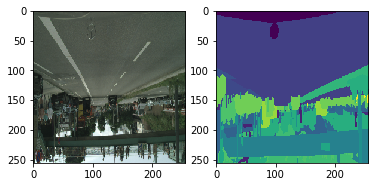

In [22]:
# 画图最后查看一下：从tf.data.Dataset拿出的数据，都是Tensor的！而matplotlib中的绘图必须是array的！
for image, label in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow( (image[0].numpy() + 1)/2 )
    plt.subplot(1,2,2)
    plt.imshow( label[0].numpy().reshape(256,256) )

### 4. 自定义网络搭建：

说明：label一共有34个类，所以最后的恢复图像的通道数应该是34！—— 从1到34！

In [27]:
label_try = read_label( train_label_path[5] )
np.unique( label_try.numpy() )
# 数值是从

array([ 1,  2,  3,  4,  6,  7,  8,  9, 11, 17, 19, 20, 21, 23, 24, 25, 26,
       32, 33], dtype=uint8)

In [38]:
# 以后把模型的自定义，都写到一个函数里 正规！—— 没有输入数据，返回一个模型！—— 层的生成，完全可以用循环！
def create_model():
    inputs = tf.keras.layers.Input( shape = (256,256,3) )  # 所有的层都是大写的！所有这也是一个层！
    
    # 前半部分卷积基自定义：顺序连接 + 用名字获得某层输出
    # 第一部分：_1
    conv2d_1_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_1' )(inputs)
    bn_1_1 = tf.keras.layers.BatchNormalization( name = 'bn_1_1' )(conv2d_1_1)
    conv2d_1_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_2' )(bn_1_1)
    bn_1_2 = tf.keras.layers.BatchNormalization( name = 'bn_1_2' )(conv2d_1_2)  # 256 x 256 x 64 √
    maxpool_1_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_1_1' )(bn_1_2)  # 128 x 128 x 64
    
    # 第二部分：_2
    conv2d_2_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_1' )(maxpool_1_1)
    bn_2_1 = tf.keras.layers.BatchNormalization( name = 'bn_2_1' )(conv2d_2_1)
    conv2d_2_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_2' )(bn_2_1)
    bn_2_2 = tf.keras.layers.BatchNormalization( name = 'bn_2_2' )(conv2d_2_2)  # 128 x 128 x 128 √
    maxpool_2_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_2_1' )(bn_2_2)  # 64 x 64 x 128
    
    # 第三部分：_3
    conv2d_3_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_1' )(maxpool_2_1)
    bn_3_1 = tf.keras.layers.BatchNormalization( name = 'bn_3_1' )(conv2d_3_1)
    conv2d_3_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_2' )(bn_3_1)
    bn_3_2 = tf.keras.layers.BatchNormalization( name = 'bn_3_2' )(conv2d_3_2)  # 64 x 64 x 256 √
    maxpool_3_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_3_1' )(bn_3_2)  # 32 x 32 x 256
    
    # 第四部分：_4
    conv2d_4_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_1' )(maxpool_3_1)
    bn_4_1 = tf.keras.layers.BatchNormalization( name = 'bn_4_1' )(conv2d_4_1)
    conv2d_4_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_2' )(bn_4_1)
    bn_4_2 = tf.keras.layers.BatchNormalization( name = 'bn_4_2' )(conv2d_4_2)  # 32 x 32 x 512 √
    maxpool_4_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_4_1' )(bn_4_2)  # 16 x 16 x 512  
    
    # 第五部分：_5 —— 最后没下采样！
    conv2d_5_1 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_1' )(maxpool_4_1)
    bn_5_1 = tf.keras.layers.BatchNormalization( name = 'bn_5_1' )(conv2d_5_1)
    conv2d_5_2 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_2' )(bn_5_1)
    bn_5_2 = tf.keras.layers.BatchNormalization( name = 'bn_5_2' )(conv2d_5_2)  # 16 x 16 x 1024
    
    
    # 后半部分自定义：反卷积 + 跳接（带√的）
    
    # 第一部分：x1、x2
    # 上采样：上采用的卷积核是(2,2)
    x1 = tf.keras.layers.Conv2DTranspose( 512, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x1')(bn_5_2)
    bn_x1 = tf.keras.layers.BatchNormalization( name = 'bn_x1' )(x1)  # 32 x 32 x 512
    # 跳接合并：当成一个层！
    x2 = tf.concat( [bn_x1, bn_4_2], axis = -1 )  # 32 x 32 x (512+512) = 32 x 32 x 1024
    conv2d_x2_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_1' )(x2)
    bn_x2_1 = tf.keras.layers.BatchNormalization( name = 'bn_x2_1' )(conv2d_x2_1)
    conv2d_x2_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_2' )(bn_x2_1)
    bn_x2_2 = tf.keras.layers.BatchNormalization( name = 'bn_x2_2' )(conv2d_x2_2)  # 32 x 32 x 512
    
    # 第二部分：x3、x4
    # 上采样：上采用的卷积核是(2,2)
    x3 = tf.keras.layers.Conv2DTranspose( 256, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x3')(bn_x2_2)
    bn_x3 = tf.keras.layers.BatchNormalization( name = 'bn_x3' )(x3)  # 64 x 64 x 256
    # 跳接合并：当成一个层！
    x4 = tf.concat( [bn_x3, bn_3_2], axis = -1 )  # 64 x 64 x (256+256) = 64 x 64 x 512
    conv2d_x4_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_1' )(x4)
    bn_x4_1 = tf.keras.layers.BatchNormalization( name = 'bn_x4_1' )(conv2d_x4_1)
    conv2d_x4_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_2' )(bn_x4_1)
    bn_x4_2 = tf.keras.layers.BatchNormalization( name = 'bn_x4_2' )(conv2d_x4_2)  # 64 x 64 x 256
    
    # 第三部分：x5、x6
    # 上采样：上采用的卷积核是(2,2)
    x5 = tf.keras.layers.Conv2DTranspose( 128, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x5')(bn_x4_2)
    bn_x5 = tf.keras.layers.BatchNormalization( name = 'bn_x5' )(x5)  # 128 x 128 x 128
    # 跳接合并：当成一个层！
    x6 = tf.concat( [bn_x5, bn_2_2], axis = -1 )  # 128 x 128 x (128+128) = 128 x 128 x 256
    conv2d_x6_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_1' )(x6)
    bn_x6_1 = tf.keras.layers.BatchNormalization( name = 'bn_x6_1' )(conv2d_x6_1)
    conv2d_x6_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_2' )(bn_x6_1)
    bn_x6_2 = tf.keras.layers.BatchNormalization( name = 'bn_x6_2' )(conv2d_x6_2)  # 128 x 128 x 128
    
    # 第四部分：x7、x8
    # 上采样：上采用的卷积核是(2,2)
    x7 = tf.keras.layers.Conv2DTranspose( 64, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x7' )(bn_x6_2)
    bn_x7 = tf.keras.layers.BatchNormalization( name = 'bn_x7' )(x7)  # 256 x 256 x 64
    # 跳接合并：当成一个层！
    x8 = tf.concat( [bn_x7, bn_1_2], axis = -1 )  # 256 x 256 x (64+64) = 256 x 256 x 128
    conv2d_x8_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_1' )(x8)
    bn_x8_1 = tf.keras.layers.BatchNormalization( name = 'bn_x8_1' )(conv2d_x8_1)
    conv2d_x8_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_2' )(bn_x8_1)
    bn_x8_2 = tf.keras.layers.BatchNormalization( name = 'bn_x8_2' )(conv2d_x8_2)  # 256 x 256 x 64
    
    # 最后的通道数变为34：卷积核为(1,1)；激活函数用softmax
    # 最后输出大小：256 x 256 x 34
    output = tf.keras.layers.Conv2D(34, kernel_size = (1,1), strides = (3,3), padding = 'same', activation = 'softmax', name = 'output')(bn_x8_2)
    
    # 模型搭建：
    model = tf.keras.Model( inputs = inputs, outputs = output )
    return model 

In [39]:
model = create_model()

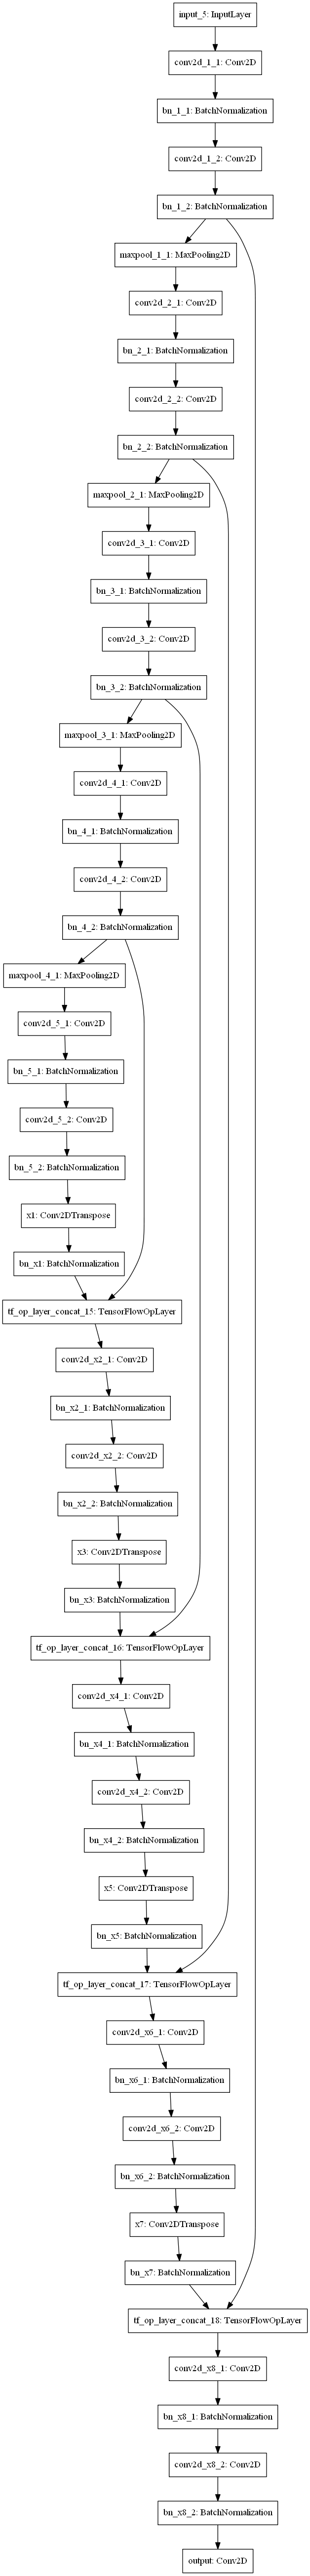

In [42]:
import os
os.environ['PATH'] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'  # 加r，防转义 
tf.keras.utils.plot_model(model, to_file = 'Unet.png')

In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1_1 (Conv2D)             (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
bn_1_1 (BatchNormalization)     (None, 256, 256, 64) 256         conv2d_1_1[0][0]                 
__________________________________________________________________________________________________
conv2d_1_2 (Conv2D)             (None, 256, 256, 64) 36928       bn_1_1[0][0]                     
____________________________________________________________________________________________

### 5. 模型配置与训练：

说明：tf.keras.metrics.MeanIoU(num_classes= 34) —— IOU评价标准，自带的函数是针对“**独热编码**”进行的！ 

故：本例中的顺序编码，需要再**重定义**一下这个类，方法直接用即可！

In [44]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.argmax(y_pred, axis = -1)
        return super().__call__(y_true, y_pred, sample_weight = sample_weight)

In [45]:
# 模型编译
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc', MeanIoU(num_classes=34)]  # 类别太多了！如果只有几个类的话，IoU的结果会非常好！
)

In [46]:
# 定义保存模型的回调函数：保存整个模型、只保存最好的！
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/Unet'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',  # 只能写一个，且不能用列表！
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

AttributeError: 'list' object has no attribute 'startswith'

In [ ]:
# 模型训练
EPOCHES = 60
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    callbacks = [cp_callback]
)